In [1]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.3 MB/s eta 0:00:0000:0100:01


In [ ]:
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense
from keras import backend as K
class ReadData:
    def __init__(self, path, subject):
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist', 'chest']
        self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
        
        os.chdir(path)
        os.chdir(subject)
        with open(subject + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        self.data = data
        
    def get_labels(self):
        return self.data[self.keys[0]]
    def get_chest_data(self):
        return self.data[self.keys[2]][self.signal_keys[1]]

In [3]:
data_path = '/kaggle/input/tiles-05-05/WESAD'
subject = 'S17'
data_target = {subject: ReadData(data_path, subject)}
chest_data_dict = data_target[subject].get_chest_data()

acc_x = chest_data_dict['ACC'][:, 0]
acc_y = chest_data_dict['ACC'][:, 1]
acc_z = chest_data_dict['ACC'][:, 2]
emg_x = chest_data_dict['EMG'][:, 0]
eda_x = chest_data_dict['EDA'][:, 0]
ecg_x = chest_data_dict['ECG'][:, 0]
temp_x = chest_data_dict['Temp'][:, 0]
resp_x = chest_data_dict['Resp'][:, 0]
w_labels = data_target[subject].data['label']

In [4]:
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values, axis=0), index=df.index, columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    return df_qn
    
df_chest = pd.DataFrame({
    'ACC_X': acc_x,
    'ACC_Y': acc_y,
    'ACC_Z': acc_z,
    'EMG': emg_x,
    'EDA': eda_x,
    'ECG': ecg_x,
    'Temp': temp_x,
    'Resp': resp_x
})
df_chest['w_labels'] = w_labels  
if 'w_labels' in df_chest.columns:
    baseline_0 = df_chest[df_chest['w_labels'] == 0]  
    baseline = df_chest[df_chest['w_labels'] == 1]    
    stress = df_chest[df_chest['w_labels'] == 2]      
    amusement = df_chest[df_chest['w_labels'] == 3]   
else:
    raise KeyError("'w_labels' column not found in df_chest")

df_0 = baseline_0.tail(10000)
df_1 = baseline.tail(10000)
df_2 = stress.tail(10000)
df_3 = amusement.tail(10000)

df_chest = pd.concat([df_3, df_1, df_2, df_0], ignore_index=True)
print("before",df_chest.shape)
print("Before Normalization:")
print(df_chest.describe())

labels_wesad = df_chest.pop('w_labels').to_numpy()
df_chest = quantile_normalize(df_chest)
print("after",df_chest.shape)
print("After Normalization:")
print(df_chest.describe())

before (40000, 9)
Before Normalization:
              ACC_X         ACC_Y         ACC_Z           EMG           EDA  \
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean       0.693697     -0.003684     -0.516699     -0.004170      6.546550   
std        0.214727      0.052481      0.293308      0.016550      0.778822   
min        0.354600     -0.148600     -0.914400     -0.183975      5.482864   
25%        0.523450     -0.047800     -0.810000     -0.012497      5.839729   
50%        0.682000      0.006200     -0.519100     -0.003937      6.629562   
75%        0.893000      0.043850     -0.210350      0.004257      7.321930   
max        1.257400      0.153400      0.082600      0.152618      7.411575   

                ECG          Temp          Resp      w_labels  
count  40000.000000  40000.000000  40000.000000  40000.000000  
mean       0.000935     33.891136      0.004522      1.500000  
std        0.304003      0.409040      5.204628      1.1

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')  
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  
    y_pred = K.cast(y_pred, dtype='float32')  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

x_train shape: (24000, 8, 8, 1), y_train shape: (24000, 4)
x_val shape: (8000, 8, 8, 1), y_val shape: (8000, 4)
x_test shape: (8000, 8, 8, 1), y_test shape: (8000, 4)


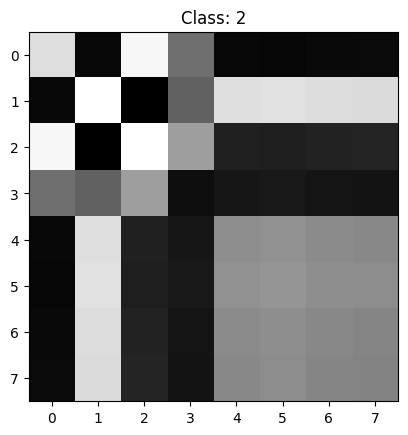

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pyts.image import GramianAngularField

gasf = GramianAngularField(method='summation')

X_train = df_chest.to_numpy()
X_train = gasf.fit_transform(X_train)

Y_train = labels_wesad.reshape(len(labels_wesad), 1)
X_train = X_train.reshape(X_train.shape[0], 8, 8, 1).astype('float32')
X_train /= np.amax(X_train)

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=4)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

plt.imshow(x_train[0, :, :, 0], cmap='gray') 
plt.title(f"Class: {np.argmax(y_train[0])}")
plt.show()

In [7]:
x_train_lstm = x_train.reshape(-1, 8, 8)
x_val_lstm = x_val.reshape(-1, 8, 8)
x_test_lstm = x_test.reshape(-1, 8, 8)

In [10]:
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam

def model_LSTM():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(8,8), activation='tanh'))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=True, activation='tanh'))
    model.add(BatchNormalization())
    model.add(LSTM(64, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(6)) 
    model.add(Dense(4, activation='softmax'))  
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
    return model
    
model=model_LSTM()

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy', f1_m, precision_m, recall_m]
)

In [11]:
model_checkpoint = callbacks.ModelCheckpoint("/kaggle/working/best_model.keras", save_best_only=True, monitor='val_loss', verbose=1)
history = model.fit(x_train_lstm, y_train, batch_size=32, epochs=100, validation_data=(x_val_lstm, y_val),callbacks=[model_checkpoint])

Epoch 1/100
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7481 - f1_m: 0.7317 - loss: 0.8252 - precision_m: 0.7949 - recall_m: 0.6820
Epoch 1: val_loss improved from inf to 0.55152, saving model to /kaggle/working/best_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.7482 - f1_m: 0.7319 - loss: 0.8249 - precision_m: 0.7950 - recall_m: 0.6822 - val_accuracy: 0.8895 - val_f1_m: 0.8889 - val_loss: 0.5515 - val_precision_m: 0.9123 - val_recall_m: 0.8675
Epoch 2/100
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8841 - f1_m: 0.8794 - loss: 0.5727 - precision_m: 0.9053 - recall_m: 0.8558
Epoch 2: val_loss improved from 0.55152 to 0.52254, saving model to /kaggle/working/best_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8841 - f1_m: 0.8794 - loss: 0.5726 - precision_m: 0.9053 - recall_m: 0.8558 - val_accuracy: 0.9100 - val_f1_m: 0.9058 - val_loss: 0.5225 - val_precision_m: 0.9238 - val_recall_m: 0.8890
Epoch 3/100
748/750 ━━━━━━━━

In [12]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test_lstm, y_test, verbose=0)
print(f"Validation Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Validation Loss: 0.448093980550766
Accuracy: 0.9588750004768372
F1 Score: 0.9589951634407043
Precision: 0.9610750079154968
Recall: 0.9570000171661377


**Visualizations**

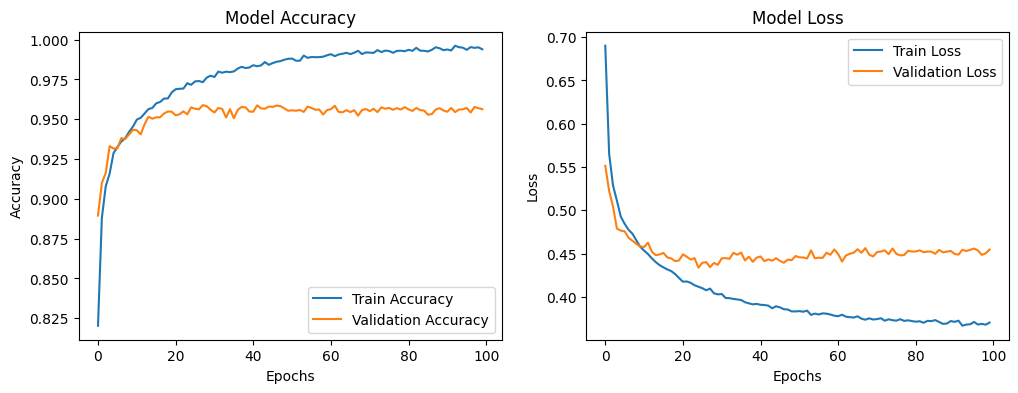

In [13]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

plot_accuracy_loss(history)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


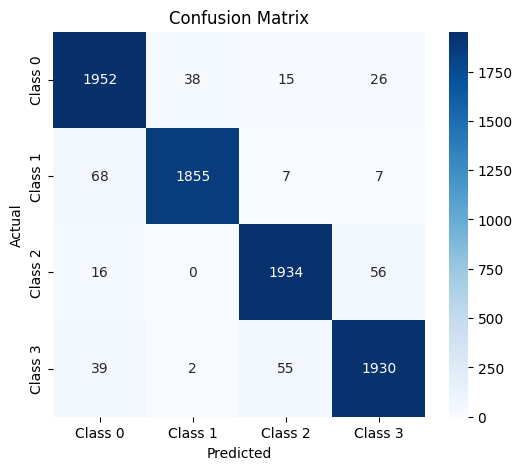

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, x_test, y_test):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    class_names = [f'Class {i}' for i in range(y_test.shape[1])]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, x_test_lstm, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


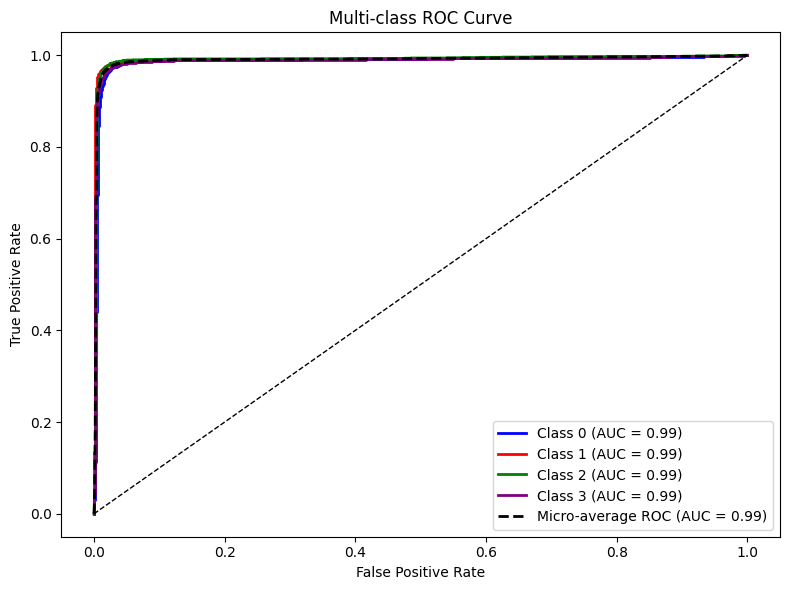

In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib.pyplot as plt

def plot_roc_curve(model, x_test, y_test):
    y_pred = model.predict(x_test)
    n_classes = y_test.shape[1]

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])

    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='black', linestyle='--', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
plot_roc_curve(model, x_test_lstm, y_test) 

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


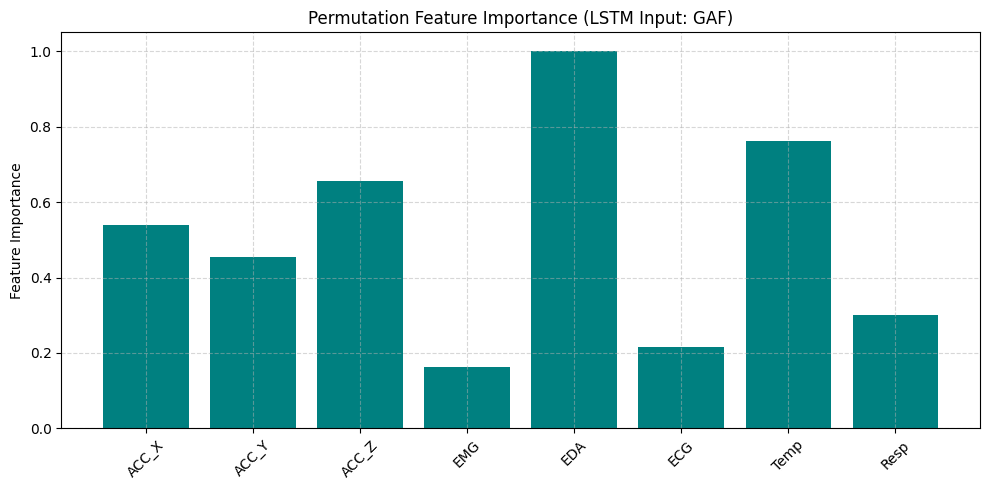

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
def permutation_importance_gaf_lstm(model, X, y_true, feature_names, base_score_fn=accuracy_score):
    """
    Computes permutation importance for GAF input of shape (N, 8, 8) — for LSTM input.
    Each original feature is encoded as a GAF image row/column.
    """
    base_preds = np.argmax(model.predict(X), axis=1)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)

    base_score = base_score_fn(y_true, base_preds)
    feature_importance = []

    for i in range(8):  # Loop through each feature (i-th row and column)
        X_permuted = np.copy(X)

        for j in range(X.shape[0]):
            row_perm = np.random.permutation(8)
            col_perm = np.random.permutation(8)

            # Permute only the i-th row and column
            X_permuted[j, i, :] = X[j, i, col_perm]  # Shuffle row i
            X_permuted[j, :, i] = X[j, row_perm, i]  # Shuffle column i

        preds = np.argmax(model.predict(X_permuted), axis=1)
        score = base_score_fn(y_true, preds)
        importance = base_score - score
        feature_importance.append(importance)

    return feature_importance
feature_names = ["ACC_X", "ACC_Y", "ACC_Z", "EMG", "EDA", "ECG", "Temp", "Resp"]
importances = permutation_importance_gaf_lstm(model, x_test_lstm, y_test, feature_names)

importances = np.array(importances)
importances /= importances.max()

plt.figure(figsize=(10, 5))
plt.bar(range(8), importances, color='teal')
plt.xticks(range(8), feature_names, rotation=45)
plt.ylabel("Feature Importance")
plt.title("Permutation Feature Importance (LSTM Input: GAF)")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()